# 1. Context and data upload

Data comes from [sg.openfoodfacts.org](https://sg.openfoodfacts.org/).

I tailored it as I only selected data from Singapore for simplicity (main website is [openfoodfacts.org](https://world.openfoodfacts.org/), but there is too much data to download and then use).

First I downloaded the CSV file (2.2Mo).
- File is now on my computer, ready to be uploaded,
- Cloud storage may be considered, but not at this point for me (paid option).

__Next step is to upload the CSV file in here.__

In [ ]:
# Upload the file on Colab (file is 2.3KB, less than 1 minute)
from google.colab import files

uploaded = files.upload()

Saving openfoodfacts_export.csv to openfoodfacts_export.csv


In [ ]:
# IDEA: append the data from Malaysia for a bigger dataset?

# IDEA 2: also append data from Thailand/Indonesia?
# -> check if product_name_(lang) is not impacted

In [ ]:
# First start by importing the packages used

# Work on data
import numpy as np
import pandas as pd
# Plot missing values
import missingno as msno
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

According to online documentation:
- file is delimited using tabulation
- file encoding is UTF-8

In [ ]:
# Read the file and create the dataset:
init_data = pd.read_csv('openfoodfacts_export.csv', sep='\t', encoding='utf-8')

<ipython-input-3-b5b70269905b>:2: DtypeWarning: Columns (1,3,4,5,6,7,9,10,11,13,14,15,16,18,19,20,22,23,24,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,67,80,81,86,87,88,89,91,92,93,94,95,96,97,98,100,101,102,103,104,105,106,107,108,109,110,111,112,114,115,150,166,172,174,176,178,180,182,184,186,188,190,192,200,204,206,208,210,222,224,226,228,236,240,252,256,260,278,280,282,284,286,290,292,294,296,314,318,319,320,321,322,323,325,326,337,343,344,345,347,348,351,352,353,354,355,356) have mixed types. Specify dtype option on import or set low_memory=False.
  init_data = pd.read_csv('openfoodfacts_export.csv', sep='\t', encoding='utf-8')


# 2. Overview of the data and pre-selection based on language

In [ ]:
# Let's have a look at the shape first:
print("This dataset contains {} rows and {} columns".format(
    init_data.shape[0], init_data.shape[1]))

This dataset contains 3456 rows and 358 columns


In [ ]:
# Display all the columns (358) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

init_data.head(5)

,code,producer_version_id,lc,product_name_ar,product_name_bg,product_name_cs,product_name_da,product_name_de,product_name_en,product_name_es,...,sources_fields:org-database-usda:publication_date,sources_fields:org-gs1:gln,sources_fields:org-gs1:gpcCategoryCode,sources_fields:org-gs1:gpcCategoryName,sources_fields:org-gs1:isAllergenRelevantDataProvided,sources_fields:org-gs1:lastChangeDateTime,sources_fields:org-gs1:partyName,sources_fields:org-gs1:productionVariantDescription,sources_fields:org-gs1:publicationDateTime,data_sources
0,8888196441119,NaN,fr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Open Food Facts"
1,4037300108293,NaN,de,NaN,NaN,NaN,NaN,Linsensuppe mit Würstchen,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Speisekammer..."
2,8076802085981,1,it,NaN,Fusilli,NaN,NaN,Fusilli,Fusilli Pasta,NaN,...,NaN,3.012289e+12,10000242.0,Pâtes/Nouilles - Non Prêt à Consomme...,True,2022-12-29T11:06:43+01:00,BARILLA FRANCE SA,1,2022-12-29T11:06:43+01:00,"Producers, Producer - Barilla, Datab..."
3,73390000110,NaN,en,NaN,NaN,NaN,NaN,NaN,Mint Mentos,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."
4,734349,NaN,en,NaN,NaN,NaN,NaN,NaN,Honey roasted cashews,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."


In [ ]:
# Some columns appear to be "duplicated" in different languages:
# - product_name_[...]
# - abbreviated_product_name_[...]
# - generic_name_[...]
# - origin_[...]
# - ingredients_text_[...]
# I will now go through these and remove the ones that are too empty.

# Start by initializing an empty list:
removed_columns = []

## 2.1. Selection of the 'product_name_[...]'

In [ ]:
# Each product is named in different languages, I'll check their completion.
# Use of RegEx: https://www.w3schools.com/python/python_regex.asp
# Display all the columns (33) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

prod_name_lang_df = init_data.filter(regex=('^product_name_'))
prod_name_lang_df.head(5)

,product_name_ar,product_name_bg,product_name_cs,product_name_da,product_name_de,product_name_en,product_name_es,product_name_et,product_name_fi,product_name_fr,...,product_name_ro,product_name_ru,product_name_sk,product_name_sr,product_name_sv,product_name_ta,product_name_th,product_name_tr,product_name_uk,product_name_zh
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Straight Red Tea,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Linsensuppe mit Würstchen,NaN,NaN,NaN,NaN,Erasco Linsen Eintopf mit Würdtchebn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Fusilli,NaN,NaN,Fusilli,Fusilli Pasta,NaN,NaN,NaN,Fusilli,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,Mint Mentos,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,Honey roasted cashews,NaN,NaN,NaN,Honey roasted cashews,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# I also save these columns in a list:
prod_name_lang_list = init_data.filter(
    regex=('^product_name_')).columns.to_list()

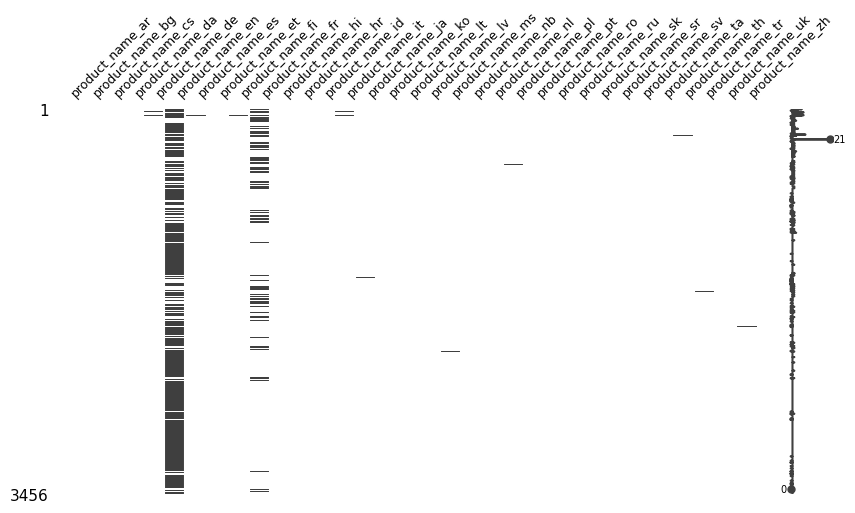

In [ ]:
_ = msno.matrix(df=prod_name_lang_df, figsize=(10,5), fontsize=9)

In [ ]:
# Since the product names are mostly available in English (also in French,
# but in a lesser extent), I only keep the '_en' variable:
prod_name_lang_list.remove('product_name_en')

In [ ]:
# I add the other columns in the removal list:
removed_columns.extend(prod_name_lang_list)

## 2.2. Selection of the 'abbreviated_product_name_[...]'

In [ ]:
# There is only one column at that time, but that may change:
abv_prod_name_lang_df = init_data.filter(regex=('^abbreviated_product_name_'))
abv_prod_name_lang_df.head(5)

,abbreviated_product_name_fr
0,NaN
1,NaN
2,Barilla fusilli 500g
3,NaN
4,NaN


In [ ]:
# I also save this column (for now?) in a list:
abv_prod_name_lang_list = init_data.filter(
    regex=('^abbreviated_product_name_')).columns.to_list()

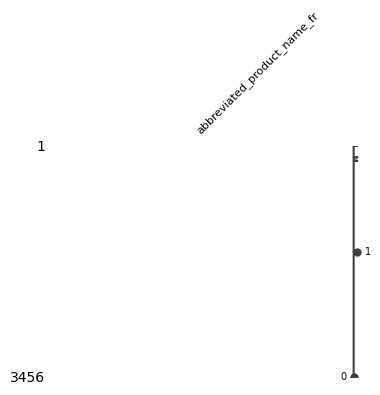

In [ ]:
_ = msno.matrix(df=abv_prod_name_lang_df, figsize=(4,3), fontsize=8)

In [ ]:
# This does not seem to be useful, so I add the column in the removal list.
removed_columns.extend(abv_prod_name_lang_list)

## 2.3. Selection of the 'generic_name_[...]'

In [ ]:
# Each product is named in different languages, I'll check their completion:
# Display all the columns (24) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

gen_name_lang_df = init_data.filter(regex=('^generic_name_'))
gen_name_lang_df.head(5)

,generic_name_ar,generic_name_bg,generic_name_cs,generic_name_da,generic_name_de,generic_name_en,generic_name_es,generic_name_et,generic_name_fi,generic_name_fr,...,generic_name_lv,generic_name_nb,generic_name_nl,generic_name_pl,generic_name_pt,generic_name_ro,generic_name_sk,generic_name_sr,generic_name_sv,generic_name_th
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pâtes alimentaires de qualité supéri...,...,NaN,NaN,NaN,NaN,Massa Fusilli,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# I also save these columns in a list:
gen_name_lang_list = init_data.filter(
    regex=('^generic_name_')).columns.to_list()

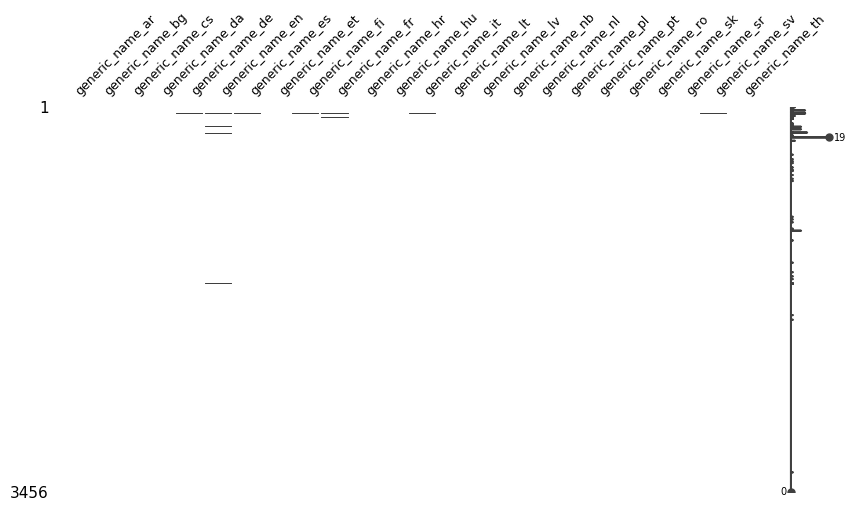

In [ ]:
_ = msno.matrix(df=gen_name_lang_df, figsize=(10,5), fontsize=9)

In [ ]:
# This does not seem to be useful, so I add the columns in the removal list:
removed_columns.extend(gen_name_lang_list)

## 2.4. Selection of the 'origin_[...]'

In [ ]:
# There are only two columns at that time, but that may change:
origin_lang_df = init_data.filter(regex=('^origin_'))
origin_lang_df.head(5)

,origin_en,origin_fr
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [ ]:
# I also save these columns in a list:
origin_lang_list = init_data.filter(regex=('^origin_')).columns.to_list()

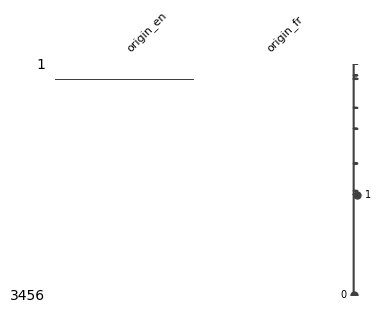

In [ ]:
_ = msno.matrix(df=origin_lang_df, figsize=(4,3), fontsize=8)

In [ ]:
# This does not seem to be useful, so I add the columns in the removal list:
removed_columns.extend(origin_lang_list)

## 2.5. Selection of the 'ingredients_text_[...]'

In [ ]:
# Ingredients are listed in different languages, I'll check their completion:
# Display all the columns (30) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

ingred_txt_lang_df = init_data.filter(regex=('^ingredients_text_'))
ingred_txt_lang_df.head(5)

,ingredients_text_bg,ingredients_text_cs,ingredients_text_da,ingredients_text_de,ingredients_text_en,ingredients_text_es,ingredients_text_et,ingredients_text_fi,ingredients_text_fr,ingredients_text_hr,...,ingredients_text_pl,ingredients_text_pt,ingredients_text_ro,ingredients_text_sk,ingredients_text_sr,ingredients_text_sv,ingredients_text_ta,ingredients_text_th,ingredients_text_uk,ingredients_text_zh
0,NaN,NaN,NaN,NaN,"Water, freshly brewed black tea, suc...",NaN,NaN,NaN,"Water, black tea, sucrose, flavourin...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,"Wasser, 32% gekochte Linsen, 6,4% Bo...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Грис от твърда пшеница, вода.",NaN,NaN,"Hartweizengrieß, Wasser.","wheat semolina, water, egg",NaN,NaN,NaN,"Semoule de BLÉ dur, eau. Peut conten...","Krupica durum pšenice, voda. Može sa...",...,NaN,"sêmola de trigo, água, ovo",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,"Sugars (sugar, wheat syrup, maltodex...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,"for best before, see cool, dry place...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# I also save these columns in a list:
ingred_txt_lang_list = init_data.filter(
    regex=('^ingredients_text_')).columns.to_list()

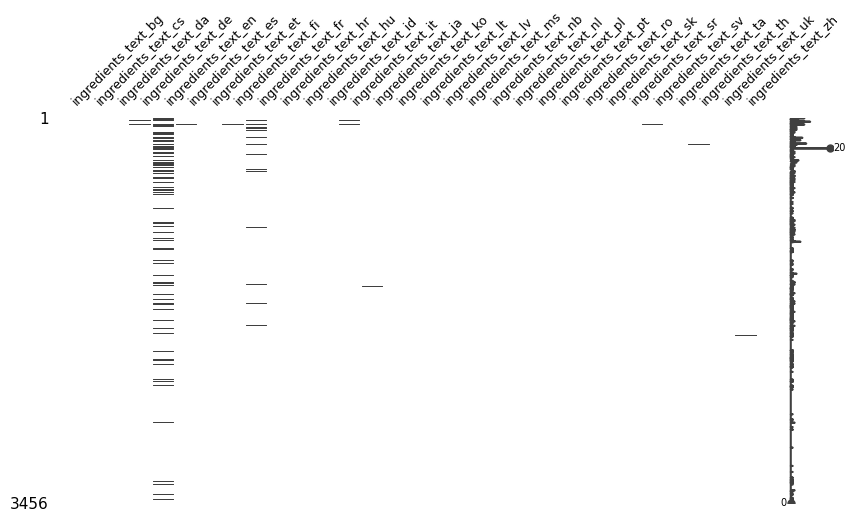

In [ ]:
_ = msno.matrix(df=ingred_txt_lang_df, figsize=(10,5), fontsize=9)

In [ ]:
# Since the ingredients are mostly available in English (also in French,
# but in a lesser extent), I only keep the '_en' variable:
ingred_txt_lang_list.remove('ingredients_text_en')

In [ ]:
# I add the other columns in the removal list:
removed_columns.extend(ingred_txt_lang_list)

# 3. Data preparation (cleaning and completion)

In [ ]:
# Let's start by removing the columns from the previous section
# init_data.columns.tolist() -> converts the columns into a list.
# Then using list comprehension to compute the difference between the two lists
# while maintaining the original order.
# I also reset the index:
prep_df = init_data[
    [col for col in init_data.columns.tolist() if
     col not in removed_columns]].reset_index(drop=True)

In [ ]:
# Let's have a look at the shape now:
print("The dataset now contains {} rows and {} columns".format(
    prep_df.shape[0], prep_df.shape[1]))

The dataset now contains 3456 rows and 270 columns


In [ ]:
# Overview of what information it contains.
# Display all the columns (270) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

prep_df.head(5)

,code,producer_version_id,lc,product_name_en,quantity,serving_size,packaging,packaging_tags,brands,brands_tags,...,sources_fields:org-database-usda:publication_date,sources_fields:org-gs1:gln,sources_fields:org-gs1:gpcCategoryCode,sources_fields:org-gs1:gpcCategoryName,sources_fields:org-gs1:isAllergenRelevantDataProvided,sources_fields:org-gs1:lastChangeDateTime,sources_fields:org-gs1:partyName,sources_fields:org-gs1:productionVariantDescription,sources_fields:org-gs1:publicationDateTime,data_sources
0,8888196441119,NaN,fr,NaN,250 ml,250 ml,en:Tetra Brick Aseptic TetraPak,en:tetra-brick-aseptic-tetrapak,Pokka,pokka,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Open Food Facts"
1,4037300108293,NaN,de,NaN,425ml,400 g,"Metall, Dose, Konserve, Stahl","en:metal,en:can,en:canned,en:steel","Erasco,Continental Foods Germany,GB ...","erasco,continental-foods-germany,gb-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Speisekammer..."
2,8076802085981,1,it,Fusilli Pasta,500 g,80 g,"Cartone, 21 PAP, Pacchetto, en:Card-box","en:cardboard,en:non-corrugated-cardb...","Barilla, Barilla und Birkel","barilla,barilla-und-birkel",...,NaN,3.012289e+12,10000242.0,Pâtes/Nouilles - Non Prêt à Consomme...,True,2022-12-29T11:06:43+01:00,BARILLA FRANCE SA,1,2022-12-29T11:06:43+01:00,"Producers, Producer - Barilla, Datab..."
3,73390000110,NaN,en,Mint Mentos,37 g,NaN,Mixed plastic-wrapper,en:mixed-plastic-wrapper,Mentos,mentos,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."
4,734349,NaN,en,Honey roasted cashews,300 g,NaN,"Pot, Jar, Pp-lid","en:pot,en:jar,en:pp-lid",Marks & Spencer,marks-spencer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"App - yuka, Apps, App - Horizon, App..."


The main idea here is:
- determine which are the most determining variables for the Nutri-Score,
- knowing the value of some of these variables for a given product, is it possible to predict its Nutri-Score?

According to its [definition](https://en.wikipedia.org/wiki/Nutri-Score), the Nutri-Score is calculated as __total N score - total P score = Nutritional score__:
- Product ingredients negatively (__N__) affecting the Nutri-Score:
  - Energy density (kcal/100g, kcal/100ml for beverages),
  - Simple sugars (g/100g, g/100ml for beverages),
  - Saturated fats (g/100g, % for cooking fats),
  - Salt (mg/100g),
- Product ingredients positively (__P__) affecting the Nutri-Score:
  - Fruit, vegetables, nuts and legumes (%),
  - Fibre (g/100g),
  - Protein (g/100g),
  - Rapeseed, walnut and olive oil (unit TBD).

Score ranges from -15 to +40, the lower the value the better the quality.

These are the columns I keep at minima.

In [ ]:
# IDEA: Use the Eco-Score and compare/use both
# https://en.wikipedia.org/wiki/Eco-score

In [ ]:
# Let's see which "scores" are available:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 40)

avail_scores = prep_df.filter(regex=('score'))
avail_scores.head(5)

,nutriscore_score_producer,nutriscore_grade_producer,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score,off:ecoscore_data.missing_key_data,off:ecoscore_data.agribalyse.code,off:ecoscore_data.adjustments.origins_of_ingredients.value,off:ecoscore_data.adjustments.packaging.value,off:ecoscore_data.adjustments.packaging.non_recyclable_and_non_biodegradable_materials,off:ecoscore_data.adjustments.production_system.value,off:ecoscore_data.adjustments.threatened_species.value
0,NaN,NaN,d,8.0,c,54.0,NaN,18015,NaN,-4.0,1.0,0.0,NaN
1,NaN,NaN,b,0.0,unknown,NaN,NaN,NaN,NaN,-2.0,0.0,0.0,NaN
2,NaN,NaN,a,-4.0,a,89.0,NaN,9810,NaN,-1.0,0.0,0.0,NaN
3,NaN,NaN,NaN,NaN,c,47.0,NaN,31003,NaN,-10.0,1.0,0.0,NaN
4,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,-12.0,0.0,0.0,NaN


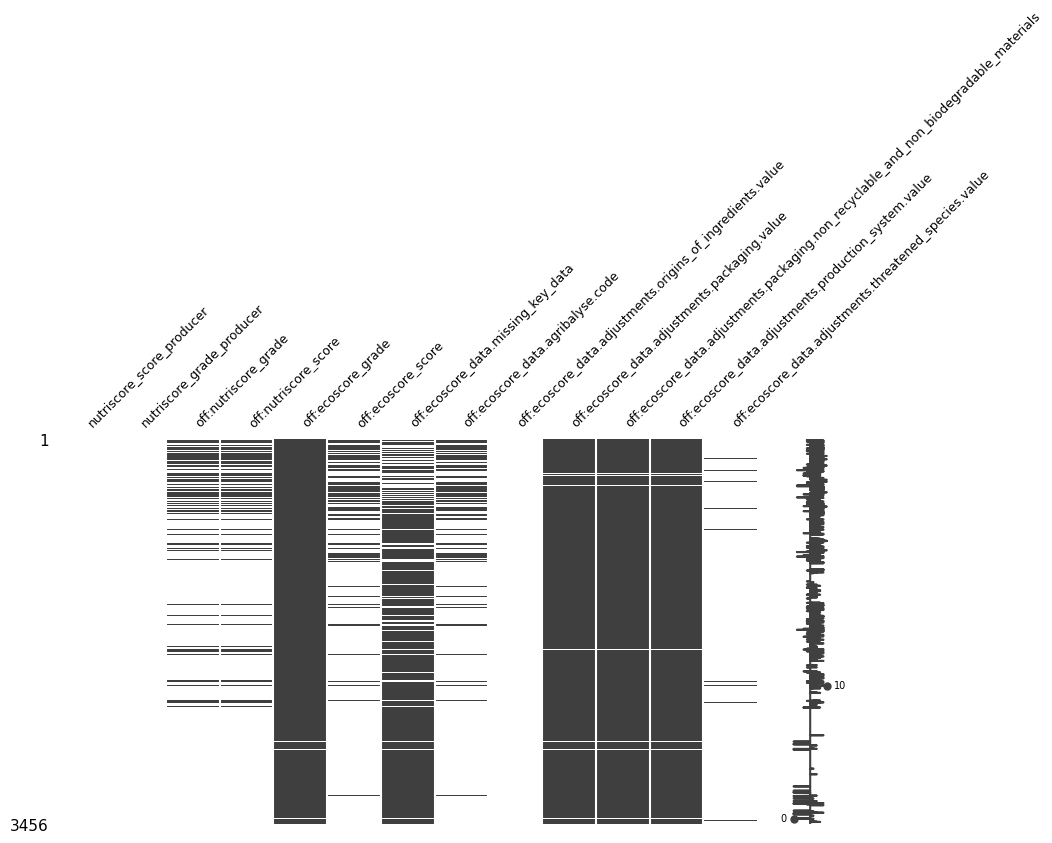

In [ ]:
_ = msno.matrix(df=avail_scores, figsize=(10,5), fontsize=9)

The Nutri-Score is not available for all the products.
Eco-Score is more present in this dataset (might be considered as the target for another study).

In [ ]:
# I can remove some columns:
dropped_columns = ['nutriscore_score_producer', 'nutriscore_grade_producer',
                   'off:ecoscore_data.missing_key_data',
                   'off:ecoscore_data.agribalyse.code',
                   'off:ecoscore_data.adjustments.origins_of_ingredients.value',
                   'off:ecoscore_data.adjustments.packaging.value',
                   'off:ecoscore_data.adjustments.packaging.non_recyclable_and_non_biodegradable_materials',
                   'off:ecoscore_data.adjustments.production_system.value',
                   'off:ecoscore_data.adjustments.threatened_species.value']

# I also reset the index
prep2_df = prep_df.drop(columns=dropped_columns).reset_index(drop=True)

## 3.1. Filtering the data according to the idea

In [ ]:
# Some columns have a keyword in common that I will use to remove some columns

# I initialize a list of columns to remove
drop_cols = []

### 3.1.1. Ending in '_tags'

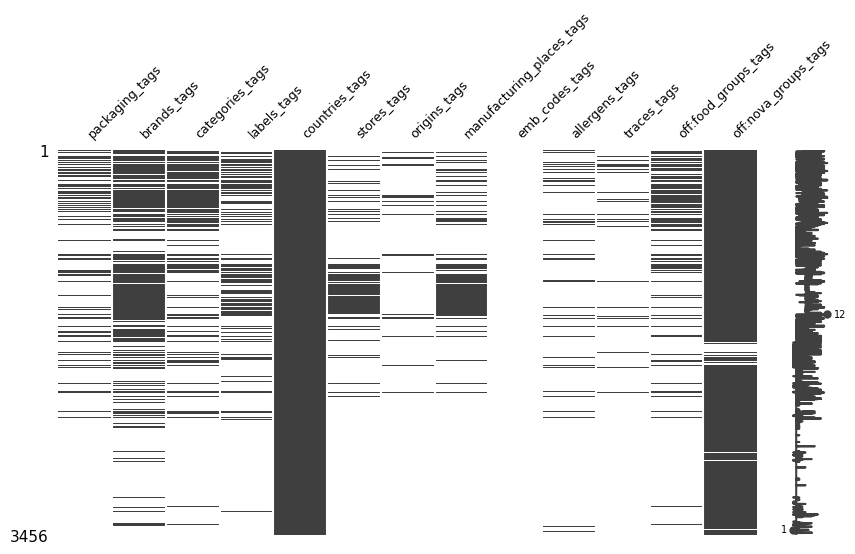

In [ ]:
# I'll start by looking at some subsets of the data
subset_df = prep2_df.filter(regex=('_tags$'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('brands_tags')
removed_list.remove('countries_tags')
removed_list.remove('off:nova_groups_tags')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.2. Containing 'energy'

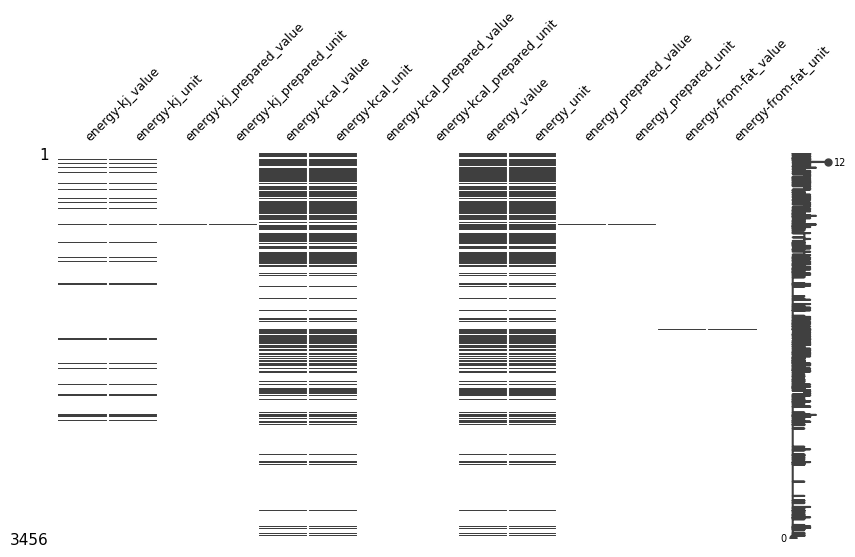

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('energy'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('energy-kcal_value')
removed_list.remove('energy-kcal_unit')
removed_list.remove('energy_value')
removed_list.remove('energy_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.3. Containing 'fat_'

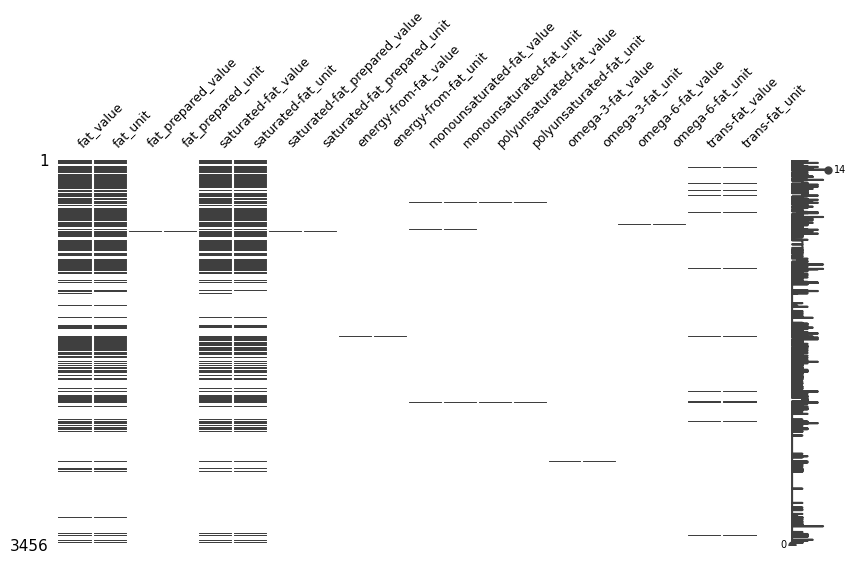

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('fat_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('fat_value')
removed_list.remove('fat_unit')
removed_list.remove('saturated-fat_value')
removed_list.remove('saturated-fat_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.4. Containing 'carbohydrates_'

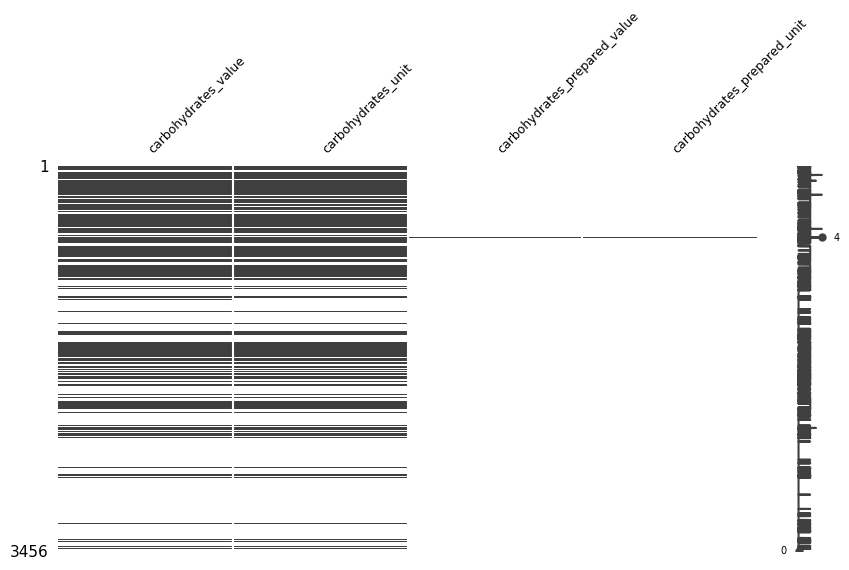

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('carbohydrates_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('carbohydrates_value')
removed_list.remove('carbohydrates_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.5. Containing 'sugars_'

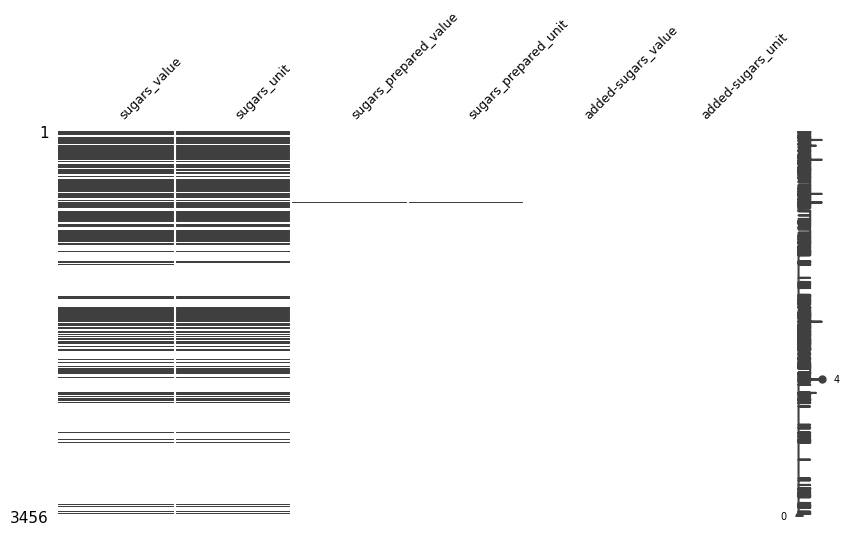

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('sugars_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('sugars_value')
removed_list.remove('sugars_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.6. Containing 'fiber_'

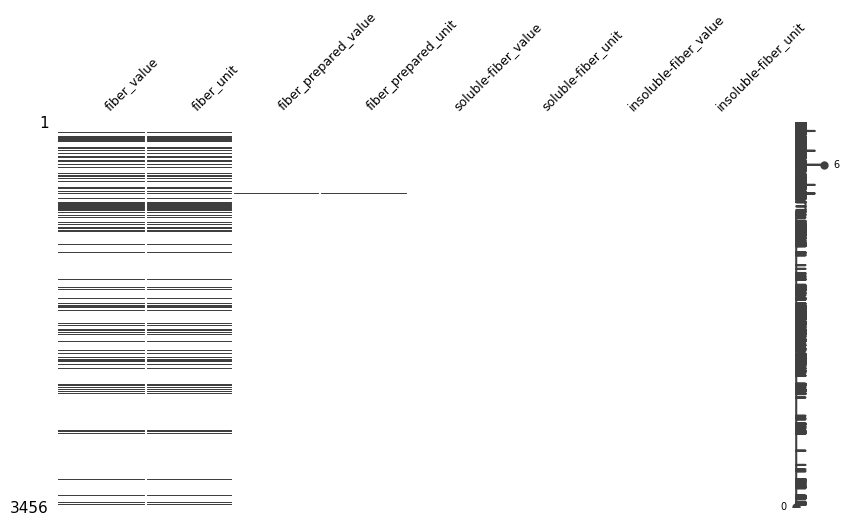

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('fiber_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('fiber_value')
removed_list.remove('fiber_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.7. Containing 'proteins_'

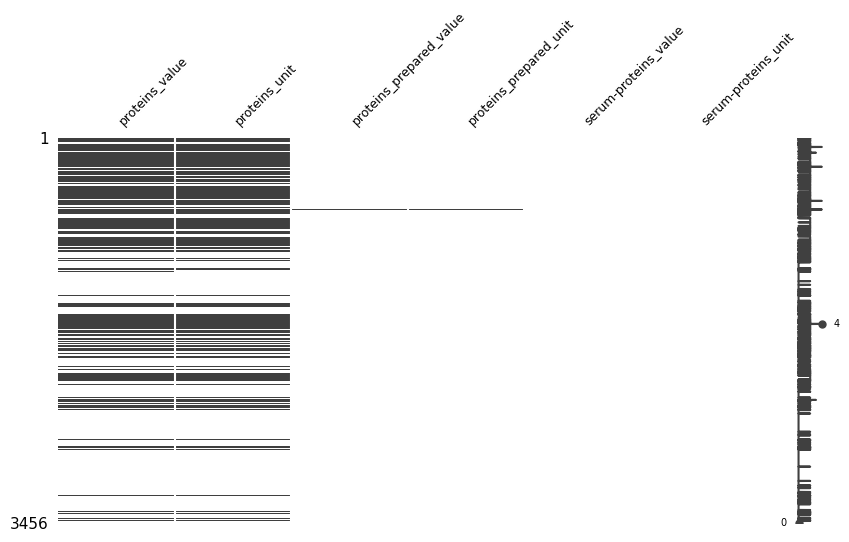

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('proteins_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('proteins_value')
removed_list.remove('proteins_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.8. Containing 'salt_'

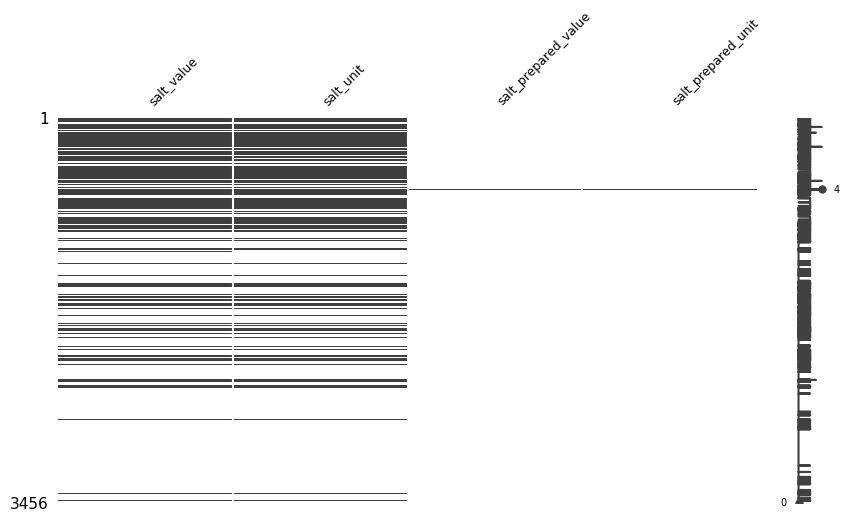

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('salt_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('salt_value')
removed_list.remove('salt_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.9. Containing 'sodium_'

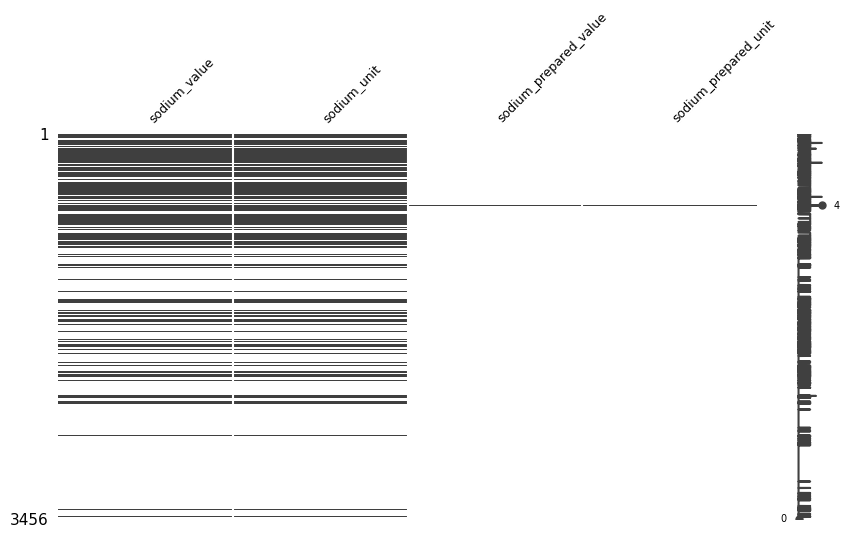

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('sodium_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the columns I want to keep
removed_list.remove('sodium_value')
removed_list.remove('sodium_unit')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

### 3.1.10. Containing '-acid_'

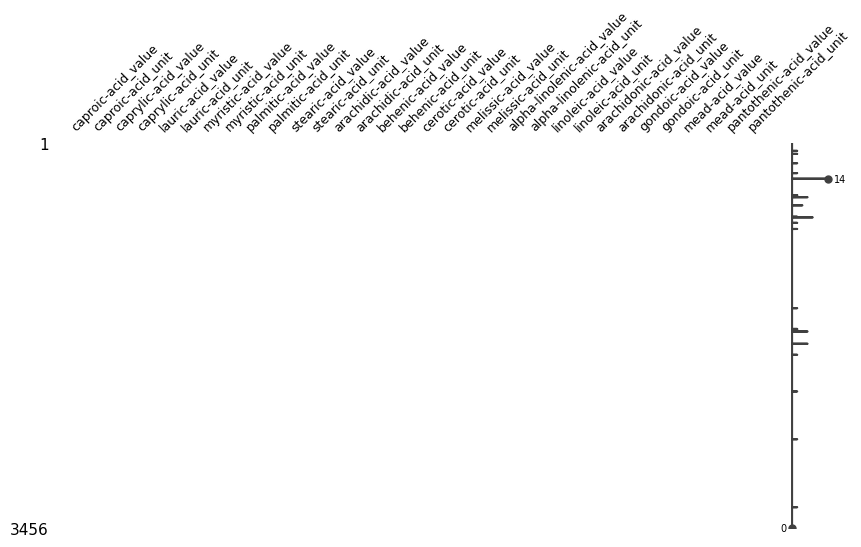

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('-acid_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# This appears to be mostly empty, so I add the whole list in the removal list
drop_cols.extend(removed_list)

### 3.1.11. Containing 'vitamin-'

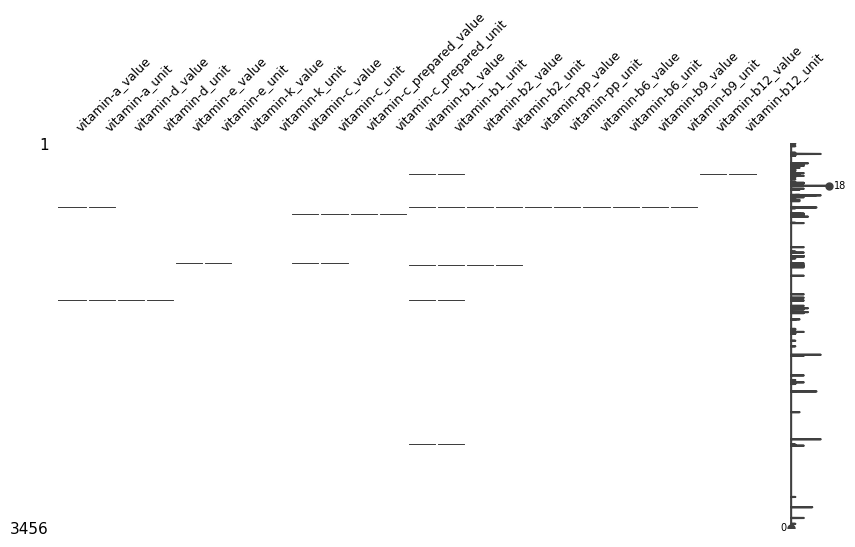

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('vitamin-'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# This appears to be mostly empty, so I add the whole list in the removal list
drop_cols.extend(removed_list)

### 3.1.12. Containing 'packaging_'

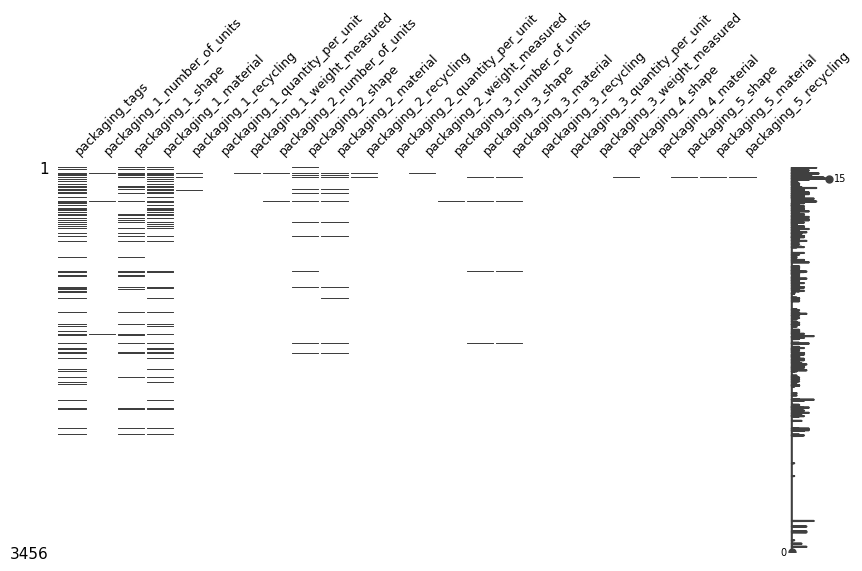

In [ ]:
# I repeat the same process for another interesting keyword
subset_df = prep2_df.filter(regex=('packaging_'))

# I also save the columns in a list:
removed_list = subset_df.columns.to_list()

_ = msno.matrix(df=subset_df, figsize=(10,5), fontsize=9)

In [ ]:
# From this (saved) list, I remove the column I want to keep
removed_list.remove('packaging_tags')

# And I add the remaining columns in the removal list
drop_cols.extend(removed_list)

## 3.2. Relevant columns selection

In [ ]:
# Let's start by removing the columns from the previous section
# prep2_df.columns.tolist() -> converts the columns into a list.
# Then using list comprehension to compute the difference of the two lists
# while maintaining the original order.
# I also reset the index:
cleaning_df = prep2_df[
    [col for col in prep2_df.columns.tolist() if
     col not in drop_cols]].reset_index(drop=True)

In [ ]:
# Let's have a look at the shape now:
print("The dataset now contains {} rows and {} columns".format(
    cleaning_df.shape[0], cleaning_df.shape[1]))

The dataset now contains 3456 rows and 128 columns


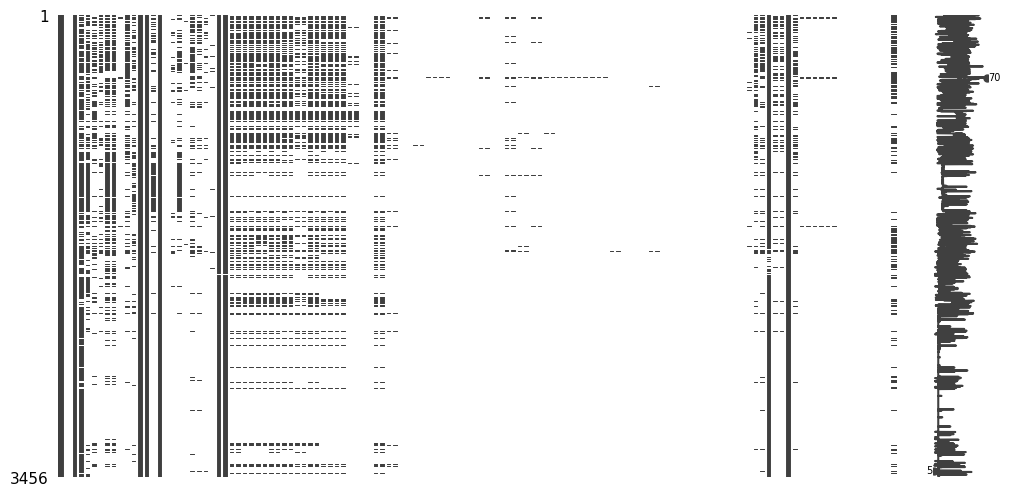

In [ ]:
_ = msno.matrix(df=cleaning_df, figsize=(12,6), fontsize=9)

In [ ]:
# "Manually" select the relevant ones here
relevant_cols = ['product_name_en', 'quantity', 'serving_size', 'labels',
                 'obsolete', 'ingredients_text_en', 'allergens', 'traces',
                 'nutrition_data_per', 'energy-kcal_value', 'energy-kcal_unit',
                 'fat_value', 'fat_unit', 'saturated-fat_value',
                 'saturated-fat_unit', 'carbohydrates_value',
                 'carbohydrates_unit', 'sugars_value', 'sugars_unit',
                 'fiber_value', 'fiber_unit', 'proteins_value', 'proteins_unit',
                 'salt_value', 'salt_unit', 'sodium_value', 'sodium_unit',
                 'alcohol_value', 'alcohol_unit', 'energy_value', 'energy_unit',
                 'fruits-vegetables-nuts_value', 'fruits-vegetables-nuts_unit',
                 'off:food_groups', 'off:nova_groups', 'off:nova_groups_tags',
                 'off:nutriscore_grade', 'off:nutriscore_score',
                 'off:ecoscore_grade', 'off:ecoscore_score']

relevant_df = cleaning_df[relevant_cols]

In [ ]:
# Automated process:
# 1. Select the columns that need NOT to be removed
# 2. Define a threshold, and remove columns that are too empty according
# to the threshold

In [ ]:
# Since my first goal is to analyze products based on their NutriScore,
# I only keep the rows where the value is not empty
selected_df = relevant_df.dropna(subset=['off:nutriscore_grade',
                                         'off:nutriscore_score'])

In [ ]:
# Let's have a look at the shape now:
print("The dataset now contains {} rows and {} columns".format(
    selected_df.shape[0], selected_df.shape[1]))

The dataset now contains 613 rows and 40 columns


In [ ]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 613 entries, 0 to 3436
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   product_name_en               494 non-null    object 
 1   quantity                      494 non-null    object 
 2   serving_size                  415 non-null    object 
 3   labels                        384 non-null    object 
 4   obsolete                      613 non-null    int64  
 5   ingredients_text_en           403 non-null    object 
 6   allergens                     266 non-null    object 
 7   traces                        127 non-null    object 
 8   nutrition_data_per            613 non-null    object 
 9   energy-kcal_value             574 non-null    float64
 10  energy-kcal_unit              574 non-null    object 
 11  fat_value                     610 non-null    float64
 12  fat_unit                      606 non-null    object 
 13  satu

In [ ]:
# Check for (and remove) duplicates
# There are none here, otherwise use: drop_duplicates()

## 3.3. Outliers and sanity checks

In [130]:
# Display all the columns (40) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)

selected_df.head()

,product_name_en,quantity,serving_size,labels,obsolete,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
0,NaN,250 ml,250 ml,"HACCP, Halal, en:Sg-healthier-choice",0,"Water, freshly brewed black tea, suc...",NaN,NaN,serving,58.000000,kcal,0.000000,g,0.0,g,14.5,g,14.5,g,0.0,g,0.0,g,37.500000,mg,15.000000,mg,NaN,NaN,243.0,kJ,NaN,NaN,en:sweetened-beverages,NaN,unknown,d,8.0,c,54.0
1,NaN,425ml,400 g,NaN,0,NaN,Senf,"Sellerie, Eier, Gluten, Milch, Soja",100g,77.000000,kcal,2.000000,g,0.8,g,9.5,g,1.3,g,2.7,g,4.2,g,0.980000,g,0.392000,g,NaN,NaN,312.0,kJ,NaN,NaN,en:one-dish-meals,4.0,en:4-ultra-processed-food-and-drink-...,b,0.0,unknown,NaN
2,Fusilli Pasta,500 g,80 g,"Vegetariano, Vegano",0,"wheat semolina, water, egg",Glutine,"Senape, Soia",100g,359.000000,kcal,2.000000,g,0.5,g,71.0,g,3.5,g,3.0,g,13.0,g,0.010000,g,0.004000,g,NaN,NaN,1521.0,kJ,NaN,NaN,en:cereals,1.0,en:1-unprocessed-or-minimally-proces...,a,-4.0,a,89.0
6,Amul Pasteurized Butter,100.0 g,100g,"Vegetarian, Green Dot India",0,"Butter, common salt. CONTAINS PERMIT...",Milk,NaN,100g,714.285714,kcal,78.571429,g,50.0,g,0.0,g,0.0,g,0.0,g,0.0,g,2.053571,g,0.821429,g,0.0,% vol,3021.0,kJ,NaN,NaN,en:fats,4.0,en:4-ultra-processed-food-and-drink-...,e,27.0,d,22.0
7,NaN,360g,NaN,"Vegetarisch, Ohne Konservierungsstof...",0,"cucumbers, vinegar, sugar, salt, dil...",Senf,NaN,100g,25.000000,kcal,0.500000,g,0.1,g,4.3,g,4.2,g,0.5,g,0.8,g,1.300000,g,0.520000,g,NaN,NaN,108.0,kJ,NaN,NaN,en:vegetables,3.0,en:3-processed-foods,c,5.0,a,110.0


In [211]:
# First, let's see if any product is "obsolete"
selected_df['obsolete'].unique()

array([0])

In [213]:
# This column can be removed
selected_df2 = selected_df.drop('obsolete', axis=1)

In [214]:
# Display all the columns (39) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)

# Then, it appears that some lines are still missing a product name
selected_df2[selected_df2['product_name_en'].isnull()]

# -> This will be filled later, but it could provide some useful information
# for the "outliers" (it could help explain)

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
0,NaN,250 ml,250 ml,"HACCP, Halal, en:Sg-healthier-choice","Water, freshly brewed black tea, suc...",NaN,NaN,serving,58.00,kcal,0.0,g,0.0,g,14.5,g,14.5,g,0.0,g,0.0,g,37.5000,mg,15.000,mg,NaN,NaN,243.00,kJ,NaN,NaN,en:sweetened-beverages,NaN,unknown,d,8.0,c,54.0
1,NaN,425ml,400 g,NaN,NaN,Senf,"Sellerie, Eier, Gluten, Milch, Soja",100g,77.00,kcal,2.0,g,0.8,g,9.5,g,1.3,g,2.7,g,4.2,g,0.9800,g,0.392,g,NaN,NaN,312.00,kJ,NaN,NaN,en:one-dish-meals,4.0,en:4-ultra-processed-food-and-drink-...,b,0.0,unknown,NaN
7,NaN,360g,NaN,"Vegetarisch, Ohne Konservierungsstof...","cucumbers, vinegar, sugar, salt, dil...",Senf,NaN,100g,25.00,kcal,0.5,g,0.1,g,4.3,g,4.2,g,0.5,g,0.8,g,1.3000,g,0.520,g,NaN,NaN,108.00,kJ,NaN,NaN,en:vegetables,3.0,en:3-processed-foods,c,5.0,a,110.0
10,NaN,250g,NaN,"Vegetarisch, Vegan, Ohne Geschmacksv...","wheat flour, palm oil, salt, 1.3 % s...",Gluten,Sesam,100g,392.00,kcal,5.9,g,0.8,g,71.0,g,3.4,g,NaN,NaN,12.0,g,4.5000,g,1.800,g,NaN,NaN,1656.00,kJ,NaN,NaN,NaN,3.0,en:3-processed-foods,d,14.0,unknown,NaN
11,NaN,60g,NaN,NaN,NaN,NaN,NaN,100g,30.00,kcal,0.5,g,0.2,g,1.9,g,0.2,g,NaN,NaN,1.3,g,5.8500,g,2.340,g,NaN,NaN,30.00,kcal,NaN,NaN,NaN,NaN,unknown,c,10.0,unknown,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,NaN,NaN,310 ml,NaN,"Water, Sugar, Mesona Frangipani, Mic...",NaN,NaN,serving,0.11,kcal,0.0,g,0.0,g,27.0,g,26.0,g,0.0,g,0.0,g,0.0000,mg,0.000,mg,NaN,NaN,0.11,kcal,NaN,NaN,en:teas-and-herbal-teas-and-coffees,NaN,unknown,d,6.0,unknown,NaN
2127,NaN,NaN,NaN,Sans conservateurs,NaN,NaN,NaN,100g,24.00,kcal,0.0,g,0.0,g,6.1,g,4.9,g,0.0,g,0.0,g,75.0000,mg,30.000,mg,NaN,NaN,101.00,kJ,NaN,NaN,NaN,NaN,unknown,d,8.0,c,44.0
2143,NaN,100 g,8.3 g,"Sans gluten, Sans sucre ajouté",NaN,NaN,NaN,100g,NaN,NaN,38.5,g,22.2,g,16.0,g,8.8,g,3.3,g,7.9,g,235.0000,mg,94.000,mg,NaN,NaN,2260.00,kJ,NaN,NaN,en:chocolate-products,NaN,unknown,d,15.0,e,18.0
2780,NaN,300 g,50 g,NaN,NaN,NaN,NaN,100g,272.00,kcal,1.1,g,0.6,g,56.0,g,9.5,g,3.0,g,7.7,g,0.0700,g,0.028,g,NaN,NaN,272.00,kcal,NaN,NaN,NaN,NaN,unknown,a,-2.0,unknown,NaN


### 3.3.1. Quantities

In [215]:
quant_cols = ['energy-kcal_value', 'fat_value', 'saturated-fat_value',
              'carbohydrates_value', 'sugars_value', 'fiber_value',
              'proteins_value', 'salt_value', 'sodium_value', 'alcohol_value',
              'energy_value', 'fruits-vegetables-nuts_value',
              'off:nutriscore_score', 'off:ecoscore_score']

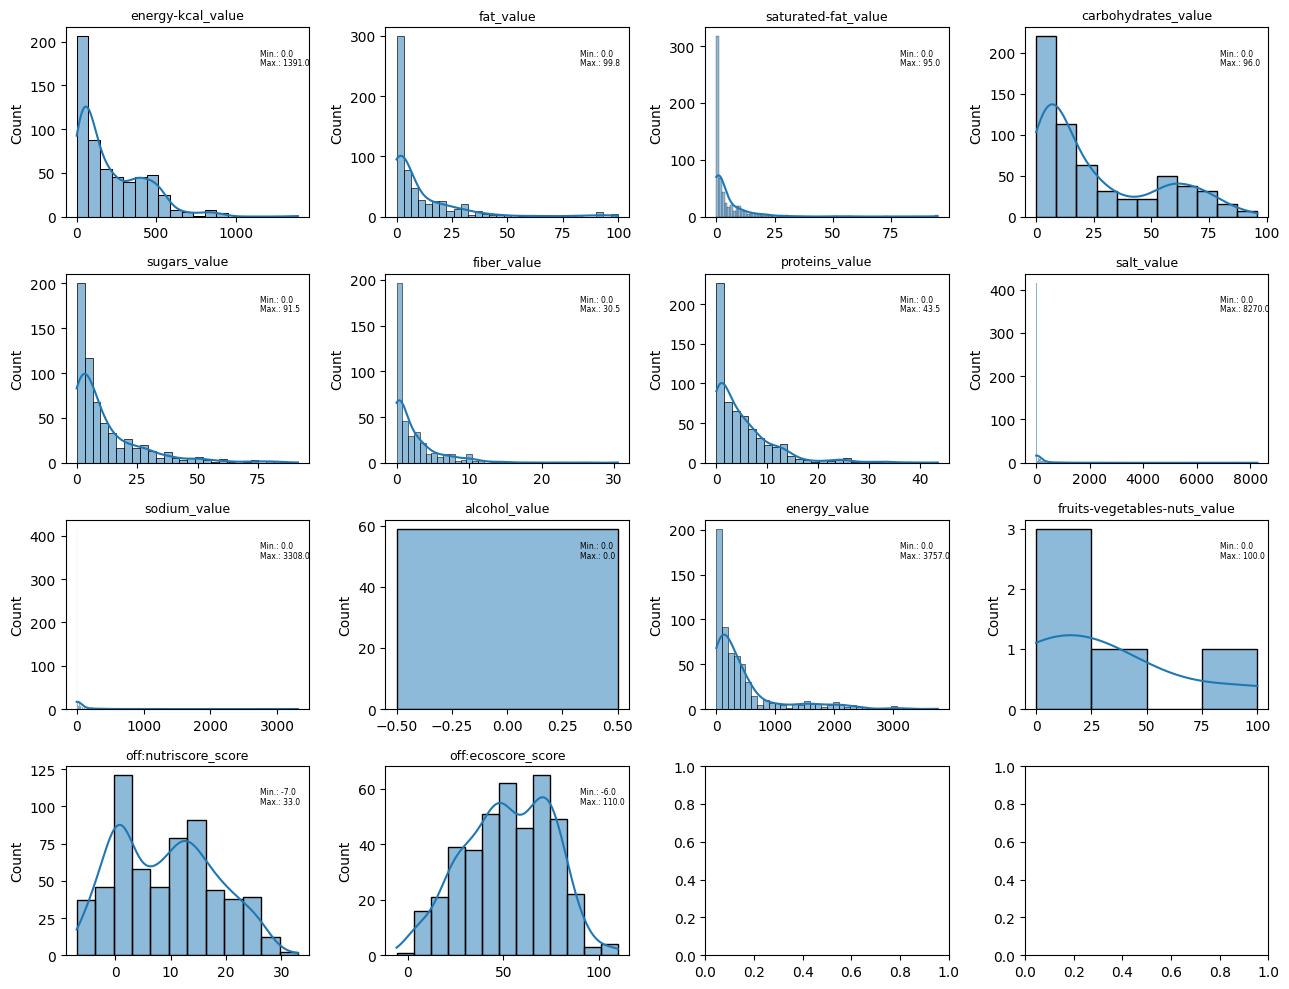

In [216]:
# Let's start by representing each variable with a histogram

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (13,10)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(4, 4)
for i in range(len(quant_cols)):
  sns.histplot(selected_df2, x=quant_cols[i], kde=True, ax=axs[i//4, i%4])
  # Remove x axis name
  axs[i//4, i%4].set(xlabel='')
  # Set the column name as title
  axs[i//4, i%4].set_title(quant_cols[i], fontsize=9)
  # Add min and max within the subplots
  axs[i//4, i%4].text(0.8, 0.85,
                      'Min.: {}'.format(selected_df2[quant_cols[i]].min()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
  axs[i//4, i%4].text(0.8, 0.8,
                      'Max.: {}'.format(selected_df2[quant_cols[i]].max()),
                      fontsize=5.5, transform=axs[i//4, i%4].transAxes)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

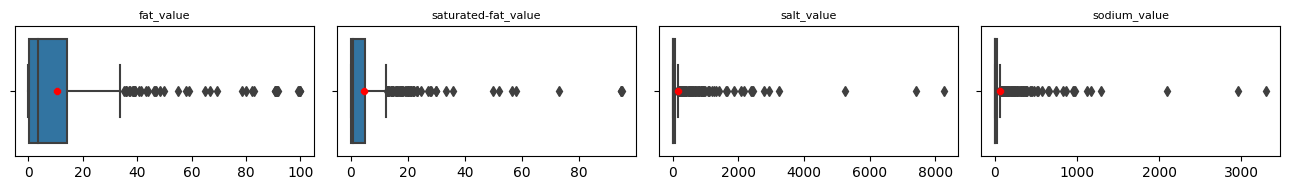

In [217]:
# There seems to be some outliers/extreme values for the following columns:
# - fat_value: high values
# - saturated-fat_value: very high values
# - salt_value: outlier(s)
# - sodium_value: outlier(s)
check_outliers = ['fat_value', 'saturated-fat_value', 'salt_value',
                  'sodium_value']

# Now let's represent these variables with a boxplot

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (13,2)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(1, 4)
for i in range(len(check_outliers)):
  sns.boxplot(selected_df2, x=check_outliers[i], orient='h', ax=axs[i],
              showmeans=True, meanprops={'marker':'8',
                                         'markerfacecolor':'red',
                                         'markeredgecolor':'red',
                                         'markersize':'5'})
  # Remove x axis name
  axs[i].set(xlabel='')
  # Set the column name as title
  axs[i].set_title(check_outliers[i], fontsize=8)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

#### Outliers for Fat

In [220]:
# Let's start by examining the outliers for the fat_value
# Display all the columns (39) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)

selected_df2[selected_df2['fat_value']>35].sort_values(by=['fat_value'],
                                                       ascending=False)

# -> The high values seem normal (as it is oil/butter/etc)

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
1679,Extra Virgin Coconut Oil,500 ml,15ml,"Organic, Non-EU Agriculture, USDA Or...",100% Organic Extra Virgin Coconut Oil,NaN,NaN,100g,898.000000,kcal,99.800000,g,94.500000,g,0.100000,g,0.000000,g,NaN,NaN,0.000000,g,0.005080,mg,0.002032,mg,NaN,NaN,898.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,20.0,unknown,NaN
320,Extra Virgin Coconut Oil,500 ml,15ml,"Organic, EU Organic, USDA Organic, H...",extra virgin Coconut Oil,NaN,NaN,100g,898.000000,kcal,99.800000,g,94.500000,g,0.100000,g,0.000000,g,NaN,NaN,0.000000,g,0.750000,mg,0.300000,mg,NaN,NaN,3757.000000,kj,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,20.0,unknown,NaN
368,Pure Ghee,400 g,14g,"Halal, ISO 9001",Clarified _butter_,Milk,NaN,100g,894.000000,kcal,99.300000,g,73.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,894.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,20.0,d,22.0
1895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,899.000000,kcal,99.000000,g,95.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,899.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,20.0,unknown,NaN
491,Olio Extra Vergine Di Oliva,1lit/Bottle,15g,NaN,100% EXTRA VIRGIN OLIVE OIL\n\nPleas...,NaN,NaN,100g,824.000000,kcal,91.600000,g,13.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,824.000000,kcal,NaN,NaN,en:fats,NaN,unknown,d,11.0,c,47.0
2361,Canola Oil,500 ml,15 ml,Halal,Canola oil.,NaN,NaN,100g,822.000000,kcal,91.300000,g,7.800000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,822.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,c,5.0,c,51.0
977,Extra Virgin Olive Oil,1 l,10 ml,"No cholesterol, No Trans Fat",100% Extra Virgin Olive Oil,NaN,NaN,100g,822.000000,kcal,91.300000,g,13.300000,g,0.000000,g,0.000000,g,NaN,NaN,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,822.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,c,6.0,c,40.0
3286,Canola,1L,NaN,"Vegetarian, No GMOs",100% Canola Seed Oil,NaN,NaN,100g,825.000000,kcal,91.100000,g,6.400000,g,0.300000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,825.000000,kcal,NaN,NaN,en:fats,NaN,unknown,c,10.0,c,42.0
937,Extra Virgin Olive Oil,1 l,15g,"No Trans Fat, Healthier-choice-singa...",Extra virgin olive oil,NaN,NaN,100g,818.000000,kcal,90.900000,g,13.200000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,818.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,c,6.0,c,40.0
424,Extra virgin olive oil,1.5 L,15ml,"Halal, Made in Spain, Healthier-choi...",Olive Oil,NaN,NaN,100g,815.000000,kcal,90.600000,g,12.300000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,815.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,c,6.0,c,53.0


#### Outliers for Saturated fat

In [221]:
# Now, let's examine the outliers for the saturated-fat_value
# Display all the columns (39) for analysis,
# Display only 20 columns for GitHub.
pd.set_option('display.max_columns', 20)

selected_df2[selected_df2['saturated-fat_value']>13].sort_values(
    by=['saturated-fat_value'], ascending=False)

# -> The high values also seem normal here

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
1895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,899.000000,kcal,99.000000,g,95.000000,g,0.000000,g,0.000000,g,0.00,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,899.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,20.0,unknown,NaN
1679,Extra Virgin Coconut Oil,500 ml,15ml,"Organic, Non-EU Agriculture, USDA Or...",100% Organic Extra Virgin Coconut Oil,NaN,NaN,100g,898.000000,kcal,99.800000,g,94.500000,g,0.100000,g,0.000000,g,NaN,NaN,0.000000,g,0.005080,mg,0.002032,mg,NaN,NaN,898.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,20.0,unknown,NaN
320,Extra Virgin Coconut Oil,500 ml,15ml,"Organic, EU Organic, USDA Organic, H...",extra virgin Coconut Oil,NaN,NaN,100g,898.000000,kcal,99.800000,g,94.500000,g,0.100000,g,0.000000,g,NaN,NaN,0.000000,g,0.750000,mg,0.300000,mg,NaN,NaN,3757.000000,kj,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,20.0,unknown,NaN
368,Pure Ghee,400 g,14g,"Halal, ISO 9001",Clarified _butter_,Milk,NaN,100g,894.000000,kcal,99.300000,g,73.000000,g,0.000000,g,0.000000,g,0.00,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,894.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,20.0,d,22.0
202,Beurre Demi Sel Echire,100g,serving,AOP,NaN,Lait,NaN,100g,720.000000,kcal,80.000000,g,58.000000,g,0.500000,g,0.500000,g,0.00,g,0.500000,g,0.000000,g,0.000000,g,NaN,NaN,720.000000,kcal,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,d,18.0,d,20.0
954,Golden Churn Butter Unsalted,227 g,10g,Halal,"PASTEURISED CREAM, LACTIC ACID, STAR...",Milk,Milk,100g,NaN,NaN,83.000000,g,56.400000,g,0.700000,g,0.700000,g,0.00,g,0.600000,g,0.025400,mg,0.010160,mg,NaN,NaN,3093.000000,kJ,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,19.0,d,33.0
1577,Butter,250g,10g,"Kosher, Halal, Made in Denmark","Cream, lactic culture, salt (1.2%). ...",Milk,NaN,100g,740.000000,kcal,82.000000,g,52.000000,g,0.700000,g,0.700000,g,NaN,NaN,0.600000,g,1.200000,g,0.480000,g,0.0,% vol,3040.000000,kJ,NaN,NaN,en:fats,2.0,en:2-processed-culinary-ingredients,e,23.0,c,51.0
6,Amul Pasteurized Butter,100.0 g,100g,"Vegetarian, Green Dot India","Butter, common salt. CONTAINS PERMIT...",Milk,NaN,100g,714.285714,kcal,78.571429,g,50.000000,g,0.000000,g,0.000000,g,0.00,g,0.000000,g,2.053571,g,0.821429,g,0.0,% vol,3021.000000,kJ,NaN,NaN,en:fats,4.0,en:4-ultra-processed-food-and-drink-...,e,27.0,d,22.0
57,NaN,NaN,NaN,"Bio, Bio européen, Commerce équitabl...",NaN,NaN,"Lait, Fruits à coque, Arachides",100g,643.000000,kcal,59.000000,g,36.000000,g,8.000000,g,0.600000,g,NaN,NaN,12.000000,g,0.000000,g,0.000000,g,NaN,NaN,643.000000,kcal,NaN,NaN,en:chocolate-products,3.0,en:3-processed-foods,d,18.0,d,30.0
1748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,621.000000,kcal,46.900000,g,33.400000,g,44.000000,g,29.200000,g,NaN,NaN,5.800000,g,20.000000,g,8.000000,g,NaN,NaN,621.000000,kcal,NaN,NaN,NaN,NaN,unknown,e,33.0,unknown,NaN


#### Outliers for Salt

In [225]:
# Now, let's examine the outliers for the salt_value
# First, it is useful to distinguish between the two units
selected_df2['salt_unit'].unique()

array(['mg', 'g', nan], dtype=object)

In [228]:
# Let's look at the rows where the unit is missing
selected_df2[selected_df2['salt_unit'].isnull()]

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
91,eau minerale,"1,5 l",NaN,NaN,NaN,NaN,NaN,100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:waters-and-flavored-waters,1.0,en:1-unprocessed-or-minimally-proces...,a,0.0,not-applicable,NaN
363,NaN,NaN,NaN,"Health Star Rating, Health Star Rati...",NaN,NaN,NaN,100g,192.0,kcal,9.0,NaN,6.0,NaN,21.0,NaN,21.0,NaN,NaN,NaN,5.0,NaN,0.000,NaN,0.0000,g,NaN,NaN,192.0,kcal,NaN,NaN,en:milk-and-yogurt,NaN,unknown,d,11.0,unknown,NaN
970,Tortilla chips tomato flavour,170 g,NaN,NaN,NaN,NaN,NaN,100g,486.0,kcal,22.9,NaN,8.7,NaN,60.4,NaN,3.7,NaN,NaN,NaN,6.7,NaN,0.339,NaN,0.1356,g,NaN,NaN,486.0,kcal,NaN,NaN,en:appetizers,NaN,unknown,d,15.0,b,67.0
1000,Singha Soda Water,325ml,325ml,NaN,NaN,NaN,NaN,100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:waters-and-flavored-waters,1.0,en:1-unprocessed-or-minimally-proces...,a,0.0,not-applicable,NaN
1021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,121.0,kcal,0.9,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.000,NaN,0.0000,g,NaN,NaN,121.0,kcal,NaN,NaN,en:bread,NaN,unknown,b,1.0,unknown,NaN
3353,agar agar,6 x 2 g,NaN,"No gluten, Organic, EU Organic",&quot;Agar from seaweed (Gelidium). ...,NaN,NaN,100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:fish-and-seafood,NaN,unknown,b,0.0,d,21.0


In [231]:
# - Row 91: can be filled with mostly 0 as it is water. Salt/Sodium values can
#   be filled with the mean value of other water
# - Row 363: can be deleted, too little information
# - Row 970: unit seems to be 'g' (same order of magnitude as sodium)
# - Row 1000: not sure. Could be same treatment as row 91
# - Row 1021: can be deleted, too little information
# - Row 3353: hard to say/infer

# Let's apply some of these. Start by removing the rows 363 and 1021
rm_outlier = selected_df2.drop(index=[363, 1021])

# Let's also add the unit for row 970
rm_outlier.loc[970, 'salt_unit'] = 'g'

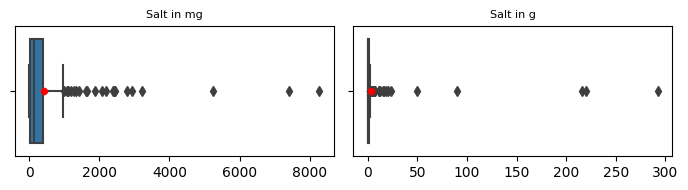

In [233]:
# Let's plot again the boxplots for each unit (excluding NaNs)

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (7,2)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

units = ['mg', 'g']

# Plot for each column
_, axs = plt.subplots(1, 2)
for i in range(2):
  sns.boxplot(rm_outlier[rm_outlier['salt_unit']==units[i]],
              x='salt_value', orient='h', ax=axs[i], showmeans=True,
              meanprops={'marker':'8',
                         'markerfacecolor':'red',
                         'markeredgecolor':'red',
                         'markersize':'5'})
  # Remove x axis name
  axs[i].set(xlabel='')
  # Set the column name as title
  axs[i].set_title('Salt in '+units[i], fontsize=8)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

##### Salt in g

In [249]:
# Now, let's examine the outliers for the salt value in g
# Display all the columns (39) for analysis,
# Display only 20 columns for GitHub.
#pd.set_option('display.max_columns', 20)

rm_outlier.loc[
    (rm_outlier['salt_unit']=='g') &
     (rm_outlier['salt_value']>5)].sort_values(by=['salt_value'],
                                                 ascending=False)

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
1514,Sweet Corn Kernel,Net Weight 425gm; Drained Weight 250gm,125g,NaN,"Ingredients: Corn, Water, Sugar, Sai...",NaN,None,serving,90.000000,kcal,1.000000,g,0.000000,g,16.000000,g,7.000000,g,4.000000,g,4.000000,g,292.100000,g,116.840000,g,NaN,NaN,90.000000,kcal,NaN,NaN,NaN,NaN,unknown,c,8.0,unknown,NaN
2365,O’Rice Natural Snow Flavour,"129g, 12 individual packs",NaN,NaN,"japonica rice 59,7%, vegetable oil (...",NaN,NaN,100g,470.000000,kcal,16.000000,g,7.000000,g,78.000000,g,13.000000,g,1.000000,g,5.000000,g,220.000000,g,88.000000,g,NaN,NaN,1970.000000,kj,NaN,NaN,NaN,4.0,en:4-ultra-processed-food-and-drink-...,e,22.0,unknown,NaN
1502,Plain Cut Slice Beetroot in Vinegar,Net Weight 3000gm/Drained Weight: 18...,28g,NaN,"Ingredients: Beetroot, Water, Vinega...",NaN,NaN,serving,15.000000,kcal,0.000000,g,0.000000,g,3.000000,g,3.000000,g,1.000000,g,0.300000,g,215.900000,g,86.360000,g,NaN,NaN,15.000000,kcal,NaN,NaN,NaN,4.0,en:4-ultra-processed-food-and-drink-...,c,9.0,unknown,NaN
2363,Wholemeal Crackers,225g (10 sachets)/7.9oz,23g,NaN,NaN,NaN,NaN,100g,110.000000,kcal,5.000000,g,2.500000,g,15.000000,g,1.000000,g,0.000000,g,2.000000,g,90.000000,g,36.000000,g,NaN,NaN,460.000000,kj,NaN,NaN,en:appetizers,NaN,unknown,d,13.0,b,67.0
2362,Wholemeal Tau Sar Pau (Red Bean Paste),"4 buns, 180g",NaN,NaN,NaN,NaN,NaN,100g,298.000000,kcal,6.100000,g,7.300000,g,52.100000,g,19.900000,g,4.100000,g,6.100000,g,50.000000,g,20.000000,g,NaN,NaN,298.000000,kcal,NaN,NaN,en:bread,NaN,unknown,e,20.0,unknown,NaN
1709,2in1 Pemang Kopi-O,28g x 20 sachets,28g,Halal,"coffee beans, sugar, margarine, salt",NaN,NaN,serving,12.000000,kcal,0.000000,g,0.000000,g,3.000000,g,3.000000,g,0.000000,g,0.000000,g,22.860000,g,9.144000,g,NaN,NaN,49.000000,kJ,NaN,NaN,NaN,3.0,en:3-processed-foods,d,12.0,unknown,NaN
1748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,621.000000,kcal,46.900000,g,33.400000,g,44.000000,g,29.200000,g,NaN,NaN,5.800000,g,20.000000,g,8.000000,g,NaN,NaN,621.000000,kcal,NaN,NaN,NaN,NaN,unknown,e,33.0,unknown,NaN
194,NaN,NaN,NaN,Sans conservateurs,NaN,NaN,NaN,100g,25.000000,kcal,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,0.000000,g,18.000000,g,7.200000,g,NaN,NaN,25.000000,kcal,NaN,NaN,en:teas-and-herbal-teas-and-coffees,NaN,unknown,e,14.0,c,43.0
181,Milo,500 g,30g,NaN,Cereal Grains {[Whole Grain Wheat (G...,"Gluten, Milk, Nuts, Soybeans",Nuts,100g,378.000000,kcal,3.500000,g,1.400000,g,74.100000,g,24.900000,g,7.500000,g,8.700000,g,16.000000,g,6.400000,g,NaN,NaN,378.000000,kcal,NaN,NaN,en:breakfast-cereals,4.0,en:4-ultra-processed-food-and-drink-...,d,15.0,e,15.0
1730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,548.000000,kcal,30.400000,g,12.800000,g,59.500000,g,0.000000,g,NaN,NaN,6.600000,g,15.000000,g,6.000000,g,NaN,NaN,548.000000,kcal,NaN,NaN,NaN,NaN,unknown,e,26.0,unknown,NaN


In [251]:
# The first rows seem to have an abnormal amount of salt:
# - Row 1514: has more salt than its serving size (292g vs 125g) -> NaN
# - Row 2365: has more salt than its unit (220g vs /100g) -> NaN
# - Row 1502: has more salt than its serving size (216g vs 28g), it can be
#   because it is expressed for the 3kg -> NaN
# - Row 2363: has too much salt (90g vs 100g), even for crackers -> NaN
# - Row 2362: same, 50% salt seems highly unlikely, it could be because it is
#   for the 4 portions instead (still a lot of salt) -> NaN
# - Row 1709: has too much salt for its serving size(23g vs 28g), it could be
#   because it is expressed for the 28g x 20 -> NaN

# Start by making a copy of the df
rm_outlier2 = rm_outlier.copy()

# While I'm at it, and since we'll see that both are correlated later,
# I also remove the values of sodium
rm_outlier2.loc[[1514, 2365, 1502, 2363, 2362, 1709], ['salt_value',
                                                       'sodium_value']] = np.nan

##### Salt in mg

In [252]:
# Now, let's examine the outliers for the salt value in g
# Display all the columns (39) for analysis,
# Display only 20 columns for GitHub.
#pd.set_option('display.max_columns', 20)

rm_outlier2.loc[
    (rm_outlier2['salt_unit']=='mg') &
     (rm_outlier2['salt_value']>900)].sort_values(by=['salt_value'],
                                                  ascending=False)

# -> Compared to the values in g, nothing stands out of the crowd here.
# A better way to detect outliers could be to create a "relative" measure:
# salt (in g) vs serving size/100g, and check the higher values.

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
1582,"Asian home gourmet, spice paste for ...",1.75 oz/50 g,1 Tbsp (13 g),NaN,"Tomato paste (23%), soybean oil, oni...",Soybeans,NaN,100g,231.0,kcal,15.38,g,0.00,g,7.69,g,7.69,g,7.7,g,7.69,g,8270.00,mg,3308.000,mg,NaN,NaN,837.0,kJ,NaN,NaN,NaN,3.0,en:3-processed-foods,c,8.0,unknown,NaN
1177,Australian Jerky Kangaroo Soft,100 g,20g,Australian made,"Kangaroo Meat, Sugar, Wheat Protein,...",Gluten,"Gluten, Soybeans",100g,NaN,NaN,1.40,g,0.30,g,16.10,g,9.60,g,NaN,NaN,43.50,g,7416.80,mg,2966.720,mg,NaN,NaN,1066.0,kJ,NaN,NaN,en:meat-other-than-poultry,4.0,en:4-ultra-processed-food-and-drink-...,d,15.0,unknown,NaN
1495,Maille Whole Grain Mustard,210 g,10 g,Made in France,NaN,NaN,NaN,100g,176.0,kcal,10.00,g,1.00,g,9.40,g,6.00,g,NaN,NaN,6.90,g,5250.00,mg,2100.000,mg,NaN,NaN,751.0,kJ,NaN,NaN,en:dressings-and-sauces,NaN,unknown,d,13.0,c,54.0
1556,Mamee Monster BBQ Flavour Snack Noodles,25g (1 Packet),25 g,Halal,"Wheat Flour, Vegetable Oil (Palm Oil...","Gluten, Soybeans","Celery, Crustaceans, Fish, Milk, Mol...",100g,451.0,kcal,15.30,g,8.00,g,67.20,g,3.70,g,3.0,g,11.10,g,3222.50,mg,1289.000,mg,NaN,NaN,1894.0,kJ,NaN,NaN,en:cereals,4.0,en:4-ultra-processed-food-and-drink-...,e,19.0,unknown,NaN
2186,Chef Arifin's Tandoori Chicken with ...,290 g,290 g,"Halal, ISO 22000","Tomato Rice (Basmati Rice, Tomato Pr...","Gluten, Milk, Soybeans","Crustaceans, Eggs, Fish, Milk, Mollu...",serving,454.3,kcal,17.30,g,4.10,g,53.90,g,4.00,g,2.2,g,19.90,g,2934.75,mg,1173.900,mg,NaN,NaN,454.3,kcal,NaN,NaN,en:one-dish-meals,4.0,en:4-ultra-processed-food-and-drink-...,b,2.0,d,20.0
1479,Italian Basil Pesto,135 g,25g,NaN,"Basil (35%) sunflower seed oil, pota...",Milk,"Milk, Nuts, Lysozyme",100g,NaN,NaN,41.40,g,6.80,g,3.70,g,2.00,g,NaN,NaN,5.40,g,2794.00,mg,1117.600,mg,NaN,NaN,1719.0,kj,NaN,NaN,en:dressings-and-sauces,4.0,en:4-ultra-processed-food-and-drink-...,e,21.0,c,51.0
138,Fine Iodized Salt,500gm/pkt,2.5g,NaN,NaN,NaN,None,serving,0.0,kcal,0.00,g,0.00,g,0.00,g,0.00,g,0.0,g,0.00,g,2447.50,mg,979.000,mg,NaN,NaN,0.0,kcal,NaN,NaN,NaN,NaN,unknown,c,10.0,unknown,NaN
116,Rendang,360 g,49.7 g,"Halal, No added MSG",RENDANG PASTE (VEGETABLE OIL (PALM O...,"Gluten, Milk, Nuts, Soybeans","Celery, Crustaceans, Eggs, Fish, Mol...",100g,443.0,kcal,38.70,g,28.00,g,18.30,g,15.70,g,3.3,g,5.30,g,2405.00,mg,962.000,mg,NaN,NaN,1861.0,kJ,NaN,NaN,en:dressings-and-sauces,4.0,en:4-ultra-processed-food-and-drink-...,e,25.0,unknown,NaN
2159,Premium Luncheon Meat,340g,NaN,HACCP,"Meat 75.51% (Pork: 43.15%, Chicken: ...","Gluten, Soybeans",NaN,100g,241.0,kcal,20.00,g,7.00,g,3.33,g,0.00,g,0.0,g,13.33,g,2375.00,mg,950.000,mg,NaN,NaN,304.0,kj,NaN,NaN,en:meat-other-than-poultry,4.0,en:4-ultra-processed-food-and-drink-...,d,16.0,unknown,NaN
2164,Mexican Rice Crackers,130g,NaN,"100% natural, Certified B Corporation","Rice, Broad Bean, _Soybean_, Rice Br...","Nuts, Soybeans",NaN,100g,700.0,kcal,29.00,g,7.00,g,92.50,g,6.00,g,10.0,g,18.00,g,2175.00,mg,870.000,mg,NaN,NaN,700.0,kcal,NaN,NaN,en:appetizers,4.0,en:4-ultra-processed-food-and-drink-...,e,19.0,b,72.0


#### Outliers for Sodium

In [253]:
# Now, let's examine the outliers for the salt_value
# First, it is useful to distinguish between the two units
rm_outlier2['sodium_unit'].unique()

array(['mg', 'g', nan], dtype=object)

In [254]:
# Let's look at the rows where the unit is missing
rm_outlier2[rm_outlier2['sodium_unit'].isnull()]

# -> These are the same as previously

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
91,eau minerale,"1,5 l",NaN,NaN,NaN,NaN,NaN,100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:waters-and-flavored-waters,1.0,en:1-unprocessed-or-minimally-proces...,a,0.0,not-applicable,NaN
1000,Singha Soda Water,325ml,325ml,NaN,NaN,NaN,NaN,100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:waters-and-flavored-waters,1.0,en:1-unprocessed-or-minimally-proces...,a,0.0,not-applicable,NaN
3353,agar agar,6 x 2 g,NaN,"No gluten, Organic, EU Organic",&quot;Agar from seaweed (Gelidium). ...,NaN,NaN,100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:fish-and-seafood,NaN,unknown,b,0.0,d,21.0


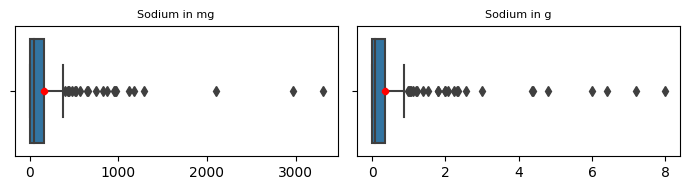

In [255]:
# Let's plot again the boxplots for each unit (excluding NaNs)

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (7,2)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

units = ['mg', 'g']

# Plot for each column
_, axs = plt.subplots(1, 2)
for i in range(2):
  sns.boxplot(rm_outlier2[rm_outlier2['sodium_unit']==units[i]],
              x='sodium_value', orient='h', ax=axs[i], showmeans=True,
              meanprops={'marker':'8',
                         'markerfacecolor':'red',
                         'markeredgecolor':'red',
                         'markersize':'5'})
  # Remove x axis name
  axs[i].set(xlabel='')
  # Set the column name as title
  axs[i].set_title('Sodium in '+units[i], fontsize=8)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

##### Sodium in g

In [256]:
# Now, let's examine the outliers for the salt value in g
# Display all the columns (39) for analysis,
# Display only 20 columns for GitHub.
#pd.set_option('display.max_columns', 20)

rm_outlier2.loc[
    (rm_outlier2['sodium_unit']=='g') &
     (rm_outlier2['sodium_value']>1)].sort_values(by=['sodium_value'],
                                                  ascending=False)

# -> These are similar to the salt products.
# There are high values, but I can't say for sure if that's too high.

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
1748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,621.000000,kcal,46.900000,g,33.400000,g,44.000000,g,29.200000,g,NaN,NaN,5.800000,g,20.000000,g,8.000000,g,NaN,NaN,621.000000,kcal,NaN,NaN,NaN,NaN,unknown,e,33.0,unknown,NaN
194,NaN,NaN,NaN,Sans conservateurs,NaN,NaN,NaN,100g,25.000000,kcal,0.000000,g,0.000000,g,0.000000,g,0.000000,g,NaN,NaN,0.000000,g,18.000000,g,7.200000,g,NaN,NaN,25.000000,kcal,NaN,NaN,en:teas-and-herbal-teas-and-coffees,NaN,unknown,e,14.0,c,43.0
181,Milo,500 g,30g,NaN,Cereal Grains {[Whole Grain Wheat (G...,"Gluten, Milk, Nuts, Soybeans",Nuts,100g,378.000000,kcal,3.500000,g,1.400000,g,74.100000,g,24.900000,g,7.500000,g,8.700000,g,16.000000,g,6.400000,g,NaN,NaN,378.000000,kcal,NaN,NaN,en:breakfast-cereals,4.0,en:4-ultra-processed-food-and-drink-...,d,15.0,e,15.0
1730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,548.000000,kcal,30.400000,g,12.800000,g,59.500000,g,0.000000,g,NaN,NaN,6.600000,g,15.000000,g,6.000000,g,NaN,NaN,548.000000,kcal,NaN,NaN,NaN,NaN,unknown,e,26.0,unknown,NaN
427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100g,18.000000,kcal,0.000000,g,0.000000,g,4.300000,g,4.300000,g,NaN,NaN,0.000000,g,12.000000,g,4.800000,g,NaN,NaN,18.000000,kcal,NaN,NaN,NaN,NaN,unknown,e,16.0,b,79.0
161,NaN,NaN,NaN,"Végétarien, Végétalien",NaN,NaN,NaN,100g,144.000000,kcal,5.600000,g,3.700000,g,23.000000,g,23.000000,g,7.300000,g,0.700000,g,11.000000,g,4.400000,g,NaN,NaN,602.000000,kj,NaN,NaN,en:ice-cream,4.0,en:4-ultra-processed-food-and-drink-...,d,14.0,b,67.0
718,Marmite Yeast Etract,115 g,4g,"Vegetarian, Halal, Halal Food Authority","Yeast Extract, Salt, Vegetable Extra...",Celery,NaN,100g,231.000000,kcal,0.100000,g,0.001000,g,19.200000,g,0.500000,g,3.100000,g,38.400000,g,10.920000,g,4.368000,g,NaN,NaN,983.000000,kJ,NaN,NaN,en:salty-and-fatty-products,3.0,en:3-processed-foods,c,9.0,unknown,NaN
1693,Gochujang,300 g,40g,"Vegetarian, Vegan, Halal","WATER, _WHEAT_, TAPIOCA SYRUP, SUGAR...","Gluten, Mustard, Soybeans",NaN,100g,266.666667,kcal,3.333333,g,0.000000,g,53.333333,g,33.333333,g,0.000000,g,6.666667,g,7.500000,g,3.000000,g,NaN,NaN,266.666667,kcal,NaN,NaN,en:dressings-and-sauces,4.0,en:4-ultra-processed-food-and-drink-...,e,20.0,unknown,NaN
88,NaN,250ml,NaN,"Vegetarisch, Ohne Konservierungsstof...","mustard seeds, vinegar, drinking wat...",Senf,NaN,100g,173.000000,kcal,12.600000,g,1.700000,g,1.500000,g,1.500000,g,NaN,NaN,8.900000,g,6.400000,g,2.560000,g,NaN,NaN,718.000000,kJ,NaN,NaN,en:dressings-and-sauces,3.0,en:3-processed-foods,d,13.0,b,65.0
11,NaN,60g,NaN,NaN,NaN,NaN,NaN,100g,30.000000,kcal,0.500000,g,0.200000,g,1.900000,g,0.200000,g,NaN,NaN,1.300000,g,5.850000,g,2.340000,g,NaN,NaN,30.000000,kcal,NaN,NaN,NaN,NaN,unknown,c,10.0,unknown,NaN


##### Sodium in mg

In [257]:
# Now, let's examine the outliers for the salt value in mg
# Display all the columns (39) for analysis,
# Display only 20 columns for GitHub.
#pd.set_option('display.max_columns', 20)

rm_outlier2.loc[
    (rm_outlier2['sodium_unit']=='mg') &
     (rm_outlier2['sodium_value']>350)].sort_values(by=['sodium_value'],
                                                    ascending=False)

# -> These are similar to the salt products.
# There are high values, but I can't say for sure if that's too high.

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
1582,"Asian home gourmet, spice paste for ...",1.75 oz/50 g,1 Tbsp (13 g),NaN,"Tomato paste (23%), soybean oil, oni...",Soybeans,NaN,100g,231.0,kcal,15.38,g,0.00,g,7.69,g,7.69,g,7.7,g,7.69,g,8270.00,mg,3308.000,mg,NaN,NaN,837.0,kJ,NaN,NaN,NaN,3.0,en:3-processed-foods,c,8.0,unknown,NaN
1177,Australian Jerky Kangaroo Soft,100 g,20g,Australian made,"Kangaroo Meat, Sugar, Wheat Protein,...",Gluten,"Gluten, Soybeans",100g,NaN,NaN,1.40,g,0.30,g,16.10,g,9.60,g,NaN,NaN,43.50,g,7416.80,mg,2966.720,mg,NaN,NaN,1066.0,kJ,NaN,NaN,en:meat-other-than-poultry,4.0,en:4-ultra-processed-food-and-drink-...,d,15.0,unknown,NaN
1495,Maille Whole Grain Mustard,210 g,10 g,Made in France,NaN,NaN,NaN,100g,176.0,kcal,10.00,g,1.00,g,9.40,g,6.00,g,NaN,NaN,6.90,g,5250.00,mg,2100.000,mg,NaN,NaN,751.0,kJ,NaN,NaN,en:dressings-and-sauces,NaN,unknown,d,13.0,c,54.0
1556,Mamee Monster BBQ Flavour Snack Noodles,25g (1 Packet),25 g,Halal,"Wheat Flour, Vegetable Oil (Palm Oil...","Gluten, Soybeans","Celery, Crustaceans, Fish, Milk, Mol...",100g,451.0,kcal,15.30,g,8.00,g,67.20,g,3.70,g,3.0,g,11.10,g,3222.50,mg,1289.000,mg,NaN,NaN,1894.0,kJ,NaN,NaN,en:cereals,4.0,en:4-ultra-processed-food-and-drink-...,e,19.0,unknown,NaN
2186,Chef Arifin's Tandoori Chicken with ...,290 g,290 g,"Halal, ISO 22000","Tomato Rice (Basmati Rice, Tomato Pr...","Gluten, Milk, Soybeans","Crustaceans, Eggs, Fish, Milk, Mollu...",serving,454.3,kcal,17.30,g,4.10,g,53.90,g,4.00,g,2.2,g,19.90,g,2934.75,mg,1173.900,mg,NaN,NaN,454.3,kcal,NaN,NaN,en:one-dish-meals,4.0,en:4-ultra-processed-food-and-drink-...,b,2.0,d,20.0
1479,Italian Basil Pesto,135 g,25g,NaN,"Basil (35%) sunflower seed oil, pota...",Milk,"Milk, Nuts, Lysozyme",100g,NaN,NaN,41.40,g,6.80,g,3.70,g,2.00,g,NaN,NaN,5.40,g,2794.00,mg,1117.600,mg,NaN,NaN,1719.0,kj,NaN,NaN,en:dressings-and-sauces,4.0,en:4-ultra-processed-food-and-drink-...,e,21.0,c,51.0
138,Fine Iodized Salt,500gm/pkt,2.5g,NaN,NaN,NaN,None,serving,0.0,kcal,0.00,g,0.00,g,0.00,g,0.00,g,0.0,g,0.00,g,2447.50,mg,979.000,mg,NaN,NaN,0.0,kcal,NaN,NaN,NaN,NaN,unknown,c,10.0,unknown,NaN
116,Rendang,360 g,49.7 g,"Halal, No added MSG",RENDANG PASTE (VEGETABLE OIL (PALM O...,"Gluten, Milk, Nuts, Soybeans","Celery, Crustaceans, Eggs, Fish, Mol...",100g,443.0,kcal,38.70,g,28.00,g,18.30,g,15.70,g,3.3,g,5.30,g,2405.00,mg,962.000,mg,NaN,NaN,1861.0,kJ,NaN,NaN,en:dressings-and-sauces,4.0,en:4-ultra-processed-food-and-drink-...,e,25.0,unknown,NaN
2159,Premium Luncheon Meat,340g,NaN,HACCP,"Meat 75.51% (Pork: 43.15%, Chicken: ...","Gluten, Soybeans",NaN,100g,241.0,kcal,20.00,g,7.00,g,3.33,g,0.00,g,0.0,g,13.33,g,2375.00,mg,950.000,mg,NaN,NaN,304.0,kj,NaN,NaN,en:meat-other-than-poultry,4.0,en:4-ultra-processed-food-and-drink-...,d,16.0,unknown,NaN
2164,Mexican Rice Crackers,130g,NaN,"100% natural, Certified B Corporation","Rice, Broad Bean, _Soybean_, Rice Br...","Nuts, Soybeans",NaN,100g,700.0,kcal,29.00,g,7.00,g,92.50,g,6.00,g,10.0,g,18.00,g,2175.00,mg,870.000,mg,NaN,NaN,700.0,kcal,NaN,NaN,en:appetizers,4.0,en:4-ultra-processed-food-and-drink-...,e,19.0,b,72.0


### 3.3.2. Qualitative variables

In [258]:
rm_outlier2.head(5)

,product_name_en,quantity,serving_size,labels,ingredients_text_en,allergens,traces,nutrition_data_per,energy-kcal_value,energy-kcal_unit,fat_value,fat_unit,saturated-fat_value,saturated-fat_unit,carbohydrates_value,carbohydrates_unit,sugars_value,sugars_unit,fiber_value,fiber_unit,proteins_value,proteins_unit,salt_value,salt_unit,sodium_value,sodium_unit,alcohol_value,alcohol_unit,energy_value,energy_unit,fruits-vegetables-nuts_value,fruits-vegetables-nuts_unit,off:food_groups,off:nova_groups,off:nova_groups_tags,off:nutriscore_grade,off:nutriscore_score,off:ecoscore_grade,off:ecoscore_score
0,NaN,250 ml,250 ml,"HACCP, Halal, en:Sg-healthier-choice","Water, freshly brewed black tea, suc...",NaN,NaN,serving,58.000000,kcal,0.000000,g,0.0,g,14.5,g,14.5,g,0.0,g,0.0,g,37.500000,mg,15.000000,mg,NaN,NaN,243.0,kJ,NaN,NaN,en:sweetened-beverages,NaN,unknown,d,8.0,c,54.0
1,NaN,425ml,400 g,NaN,NaN,Senf,"Sellerie, Eier, Gluten, Milch, Soja",100g,77.000000,kcal,2.000000,g,0.8,g,9.5,g,1.3,g,2.7,g,4.2,g,0.980000,g,0.392000,g,NaN,NaN,312.0,kJ,NaN,NaN,en:one-dish-meals,4.0,en:4-ultra-processed-food-and-drink-...,b,0.0,unknown,NaN
2,Fusilli Pasta,500 g,80 g,"Vegetariano, Vegano","wheat semolina, water, egg",Glutine,"Senape, Soia",100g,359.000000,kcal,2.000000,g,0.5,g,71.0,g,3.5,g,3.0,g,13.0,g,0.010000,g,0.004000,g,NaN,NaN,1521.0,kJ,NaN,NaN,en:cereals,1.0,en:1-unprocessed-or-minimally-proces...,a,-4.0,a,89.0
6,Amul Pasteurized Butter,100.0 g,100g,"Vegetarian, Green Dot India","Butter, common salt. CONTAINS PERMIT...",Milk,NaN,100g,714.285714,kcal,78.571429,g,50.0,g,0.0,g,0.0,g,0.0,g,0.0,g,2.053571,g,0.821429,g,0.0,% vol,3021.0,kJ,NaN,NaN,en:fats,4.0,en:4-ultra-processed-food-and-drink-...,e,27.0,d,22.0
7,NaN,360g,NaN,"Vegetarisch, Ohne Konservierungsstof...","cucumbers, vinegar, sugar, salt, dil...",Senf,NaN,100g,25.000000,kcal,0.500000,g,0.1,g,4.3,g,4.2,g,0.5,g,0.8,g,1.300000,g,0.520000,g,NaN,NaN,108.0,kJ,NaN,NaN,en:vegetables,3.0,en:3-processed-foods,c,5.0,a,110.0


#### Quantity, Serving size and Nutrition_data_per

In [ ]:
# TBD

# "Harmonize" values

#### Labels

In [ ]:
# TBD

# Create columns (Bio, Vegetarian, Vegan, etc)

In [262]:
rm_outlier2['labels'].unique()

# Halal
# SG_healthy
# Vegetarian
# Vegan
# Lactose_free
# Gluten_free
# Bio

array(['HACCP, Halal, en:Sg-healthier-choice', nan, 'Vegetariano, Vegano',
       'Vegetarian, Green Dot India',
       'Vegetarisch, Ohne Konservierungsstoffe, Vegan, Grüner Punkt, Hergestellt in Deutschland',
       'Vegetarisch, Vegan, Ohne Geschmacksverstärker, Nutriscore, Nutriscore D',
       'Vegetarisch, Vegan, Europäische Vegetarier-Union, Europäische Vegetarier-Union Vegan, Grüner Punkt, Nutriscore, Nutriscore B',
       'No lactose', 'Designated Origin Denomination, PDO',
       'No gluten, Halal, Verified\n', 'No preservatives',
       'Glutenfrei, Vegetarisch, Vegan, Hergestellt in Deutschland, Metal recycles forever',
       'No gluten, Green Dot, Made in the EU, Rainforest Alliance, Rainforest Alliance Cocoa, Tidy man',
       'Halal, en:Halal Food Council of Europe',
       'Low or no sugar, High proteins, No added sugar, Goodness-of-calcium',
       'Green Dot, Made in Italy', 'Point Vert, Tidy man',
       'Vegetarian, Made in Italy',
       'Bio, Bio européen, Commer

#### Ingredients, Traces and Allergens

In [260]:
# TBD

# Create columns for allergens, check/confirm with ingredients/traces

#### Groups/Scores

In [261]:
# TBD

In [ ]:
# food_groups

In [ ]:
# nova_groups and nova_groups_tags

In [ ]:
# nutriscore_grade and nutriscore_score

In [ ]:
# ecoscore_grade and ecoscore_score

## 3.4. Correlated variables

## 3.5. Missing values

In [ ]:
# NEXT STEPS:

# Check for outliers:
# - check for bounded "lists": e.g. Nutri-Score <A, B, C, D, E>

# Check for correlation:
# - energy-kcal and energy
# - fat and saturated-fat
# - carbohydrates and sugars
# - salt and sodium

# Deal with missing values:
# - 'object' columns filled with 'Unknown' or 'missing'
# - quantitative with mean OR IterativeImputer OR k-NN (OR ?)

# Nova group = how "processed" is a food. Ranges from 1 (not processed) to 4